In [1]:
%matplotlib inline
#import sys, traceback
import cv2
from PIL import Image
import imutils
#import zbarlight
#import numpy as np
import matplotlib
#import matplotlib.pyplot as plt
#matplotlib.use("TkAgg")
from plantcv import plantcv as pcv

pcv.params.debug = 'plot'                     # Plot debug images to the notebook
img_file = '/home/leonard/Documents/Uni/PhD/Phenotyping/2020-01_LAC_phenotyping/images/front/renamed/20200421_Q-17_5.jpg'
ref_file = '/home/leonard/Dropbox/2020-01_LAC_phenotyping/images/front/renamed/20200416_Col-0_1.jpg'
qr_file = '/home/leonard/Dropbox/DSC_0094.JPG'


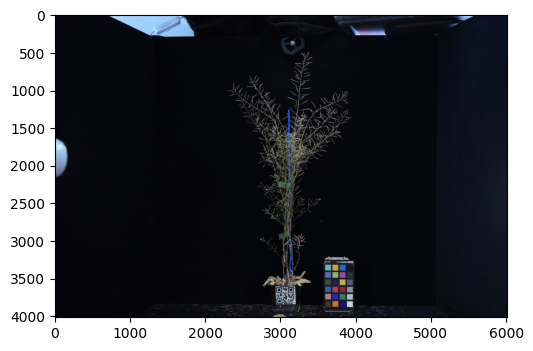

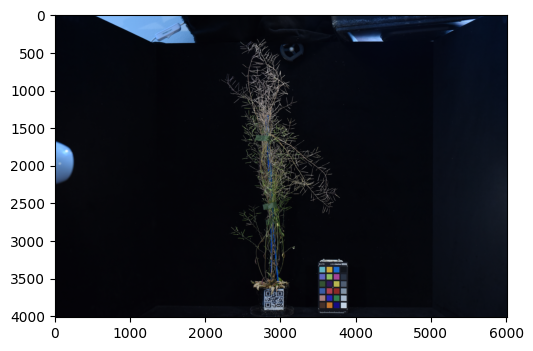

In [2]:
### Main pipeline

    # Read target image
    img, path, filename = pcv.readimage(filename = img_file, mode = "native")
    # remove oversaturated pixels
    #start_mask, img = pcv.threshold.custom_range(img, lower_thresh=[0,0,0], upper_thresh=[254,254,254], channel='RGB')
    #start_mask, img = pcv.threshold.custom_range(img, lower_thresh=[0,0,0], upper_thresh=[255,254,255], channel='HSV')
    pcv.print_image(img, "img.png")
    
    # Read ref image
    ref_img, ref_path, ref_filename = pcv.readimage(filename = ref_file, mode = "native")
    # remove oversaturated pixels
    #start_ref_mask, ref_img = pcv.threshold.custom_range(ref_img, lower_thresh=[0,0,0], upper_thresh=[254,254,254], channel='RGB')
    #start_ref_mask, ref_img = pcv.threshold.custom_range(ref_img, lower_thresh=[0,0,0], upper_thresh=[255,254,255], channel='HSV')

In [3]:
%%capture
# find colour card in reference image
df, start, space = pcv.transform.find_color_card(rgb_img=ref_img)
target_mask = pcv.transform.create_color_card_mask(rgb_img=ref_img, radius=10, start_coord=start, spacing=space, ncols=4, nrows=6)

# find colour card in the image to be analysed
df, start, space = pcv.transform.find_color_card(rgb_img=img)
source_mask = pcv.transform.create_color_card_mask(rgb_img=img, radius=10, start_coord=start, spacing=space, ncols=4, nrows=6)

output_directory = "."

# correct colour
target_matrix, source_matrix, transformation_matrix, corrected_img = pcv.transform.correct_color(ref_img, target_mask, img, source_mask, output_directory)

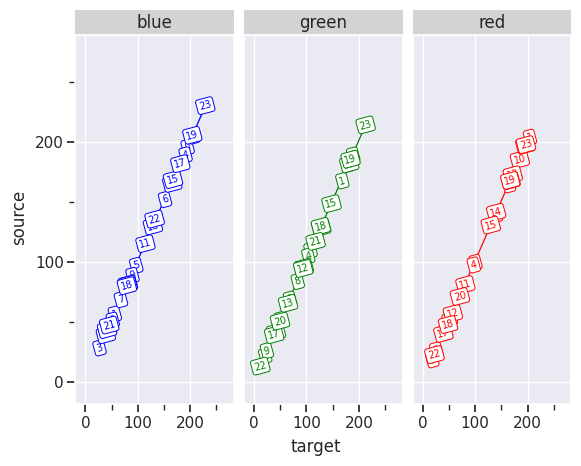

<ggplot: (-9223363294420526076)>


In [4]:
# check that the colour correction worked (source~target should be strictly linear)
pcv.transform.quick_color_check(source_matrix = source_matrix, target_matrix = target_matrix, num_chips = 24)

In [5]:
#define a bounding rectangle around the colour card
x_cc,y_cc,w_cc,h_cc = cv2.boundingRect(source_mask)
x_cc = int(round(x_cc - 0.3 * w_cc))
y_cc = int(round(y_cc - 0.3 * h_cc))
h_cc = int(round(h_cc * 1.6))
w_cc = int(round(w_cc * 1.6))

In [6]:
# Crop out colour card
start_point = (x_cc, y_cc)
end_point = (x_cc+w_cc, y_cc+h_cc)
colour = (0, 0, 0)
thickness = -1
crop_img = cv2.rectangle(corrected_img, start_point, end_point, colour, thickness)

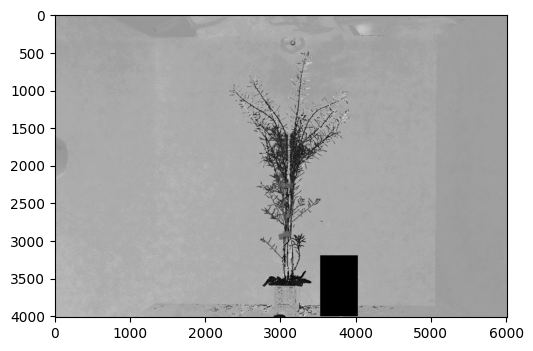

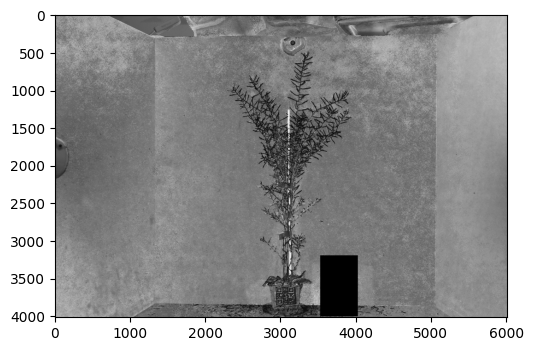

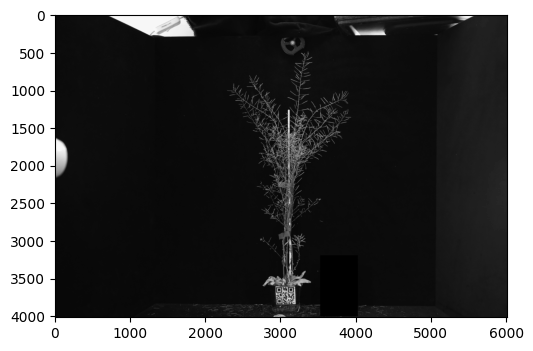

In [7]:
# Convert RGB to HSV and extract the hue and value channels
pcv.print_image(corrected_img, "corrected_img.png")
h = pcv.rgb2gray_hsv(corrected_img, "h")
s = pcv.rgb2gray_hsv(corrected_img, "s")
v = pcv.rgb2gray_hsv(corrected_img, "v")

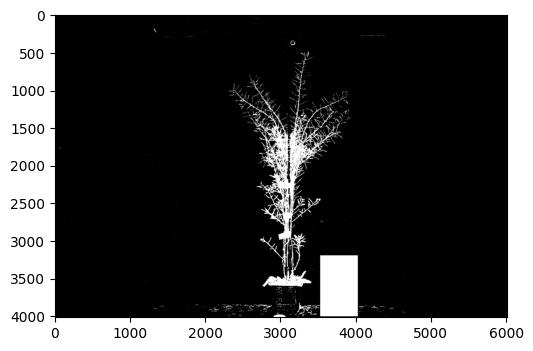

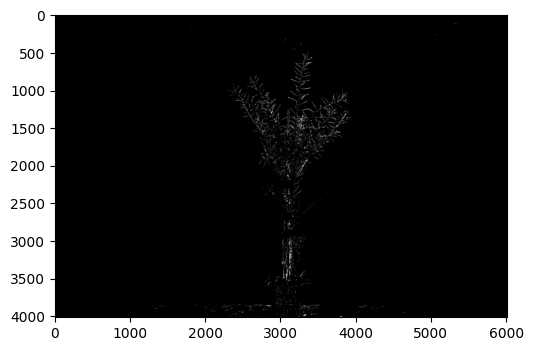

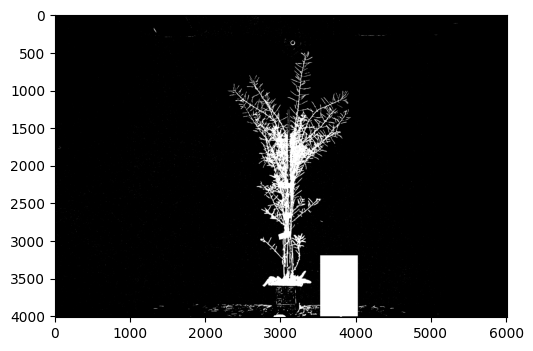

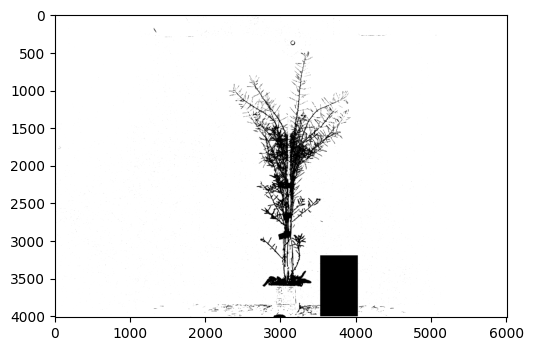

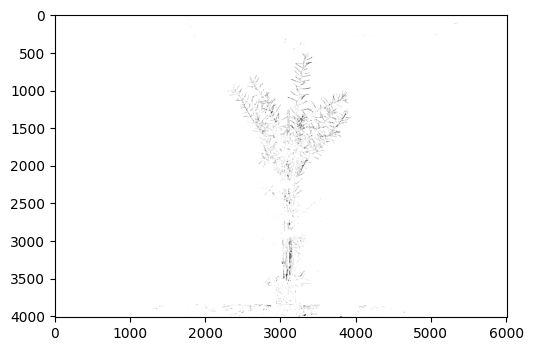

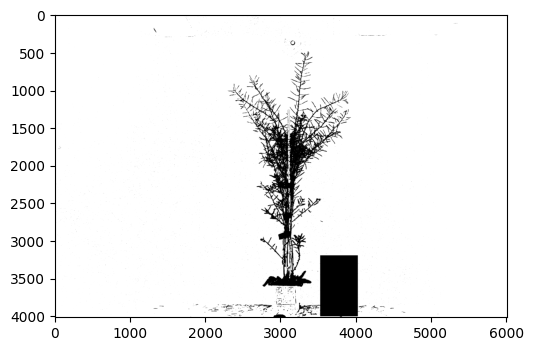

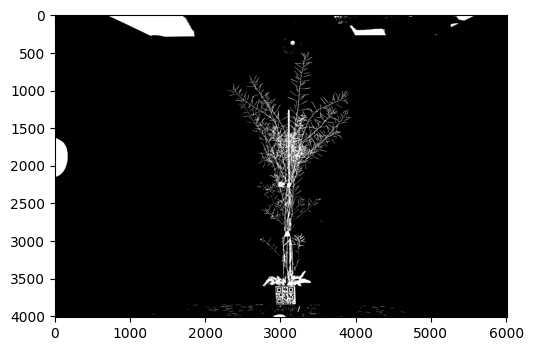

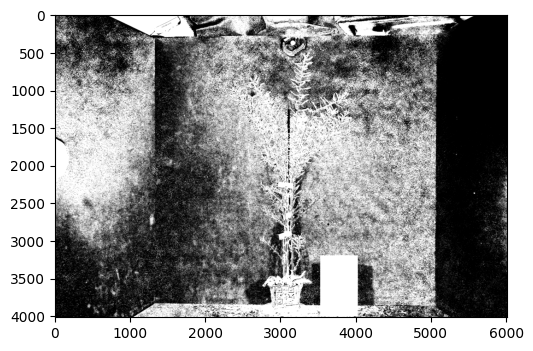

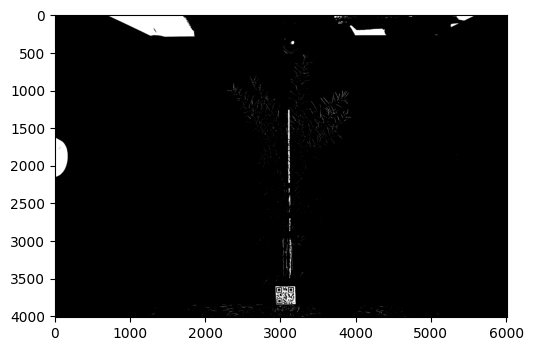

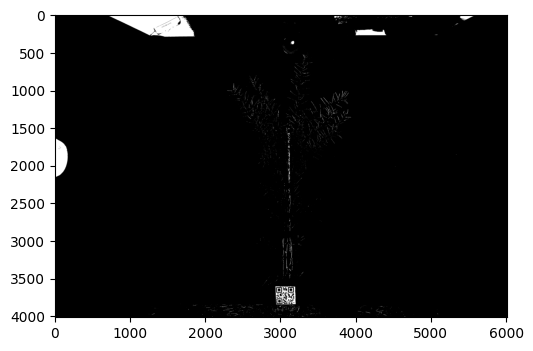

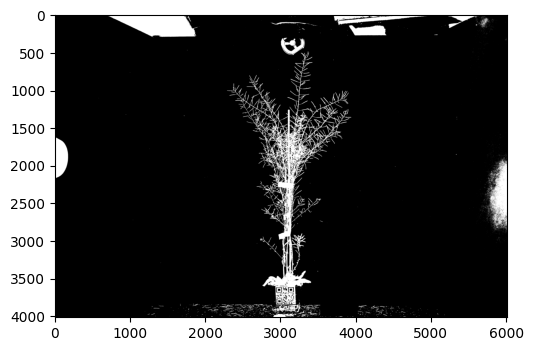

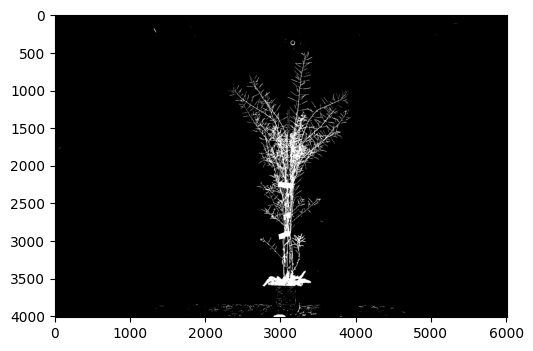

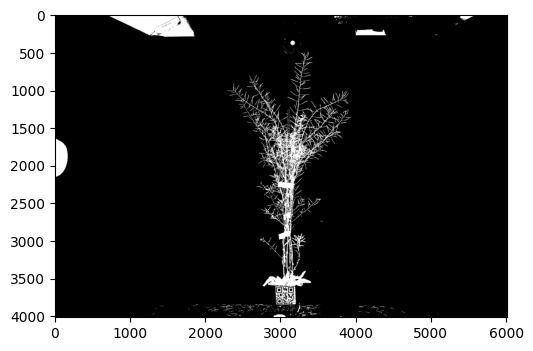

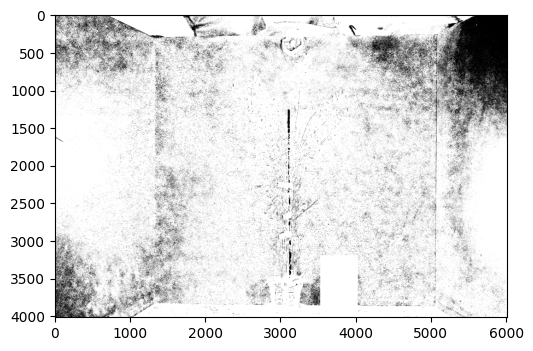

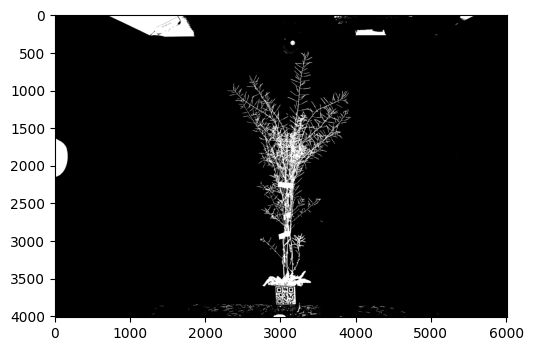

In [8]:
# Threshold the hue image to cut out the blue range
h_thresh_green = pcv.threshold.binary(h, 100, 255, "dark")
h_thresh_red = pcv.threshold.binary(h, 150, 255, "light")
h_thresh = pcv.logical_or(h_thresh_green, h_thresh_red)

# Find light blue
h_thresh_blue1 = pcv.threshold.binary(h, 100, 255, "light")
h_thresh_blue2 = pcv.threshold.binary(h, 150, 255, "dark")
h_thresh_blue = pcv.logical_and(h_thresh_blue1, h_thresh_blue2)
v_thresh_blue = pcv.threshold.binary(v, 80, 255, "light")
s_thresh_blue = pcv.threshold.binary(s, 120, 255, "dark")
hv_thresh_blue = pcv.logical_and(h_thresh_blue, v_thresh_blue)
thresh_blue = pcv.logical_and(hv_thresh_blue, s_thresh_blue)

pcv.print_image(s_thresh_blue, "blue_threshold.png")

pcv.print_image(h_thresh, "h_threshold.png")

# Threshold the value image to remove black background and very light correction artifacts
v_thresh = pcv.threshold.binary(v, 35, 255, "light")
pcv.print_image(v_thresh, "v_threshold.png")

# Keep pixels selected by both thresholding approaches
hv_thresh = pcv.logical_and(h_thresh, v_thresh)
hsv_thresh = pcv.logical_or(hv_thresh, thresh_blue)
#hsv_dilated = pcv.dilate(hsv_thresh, 25, 1)

# Temporary fix for colour artifacts
s_thresh_art = pcv.threshold.binary(s, 160, 255, "dark")
hsv_thresh = pcv.logical_and(hsv_thresh, s_thresh_art)

pcv.print_image(hsv_thresh, "hsv_thresh.png")

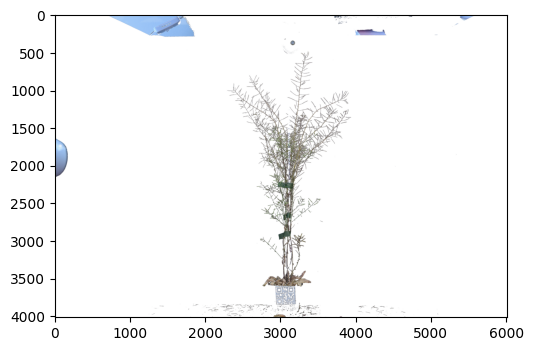

In [9]:
# Apply Mask (for VIS images, mask_color=white)
masked = pcv.apply_mask(corrected_img, hsv_thresh, "white")

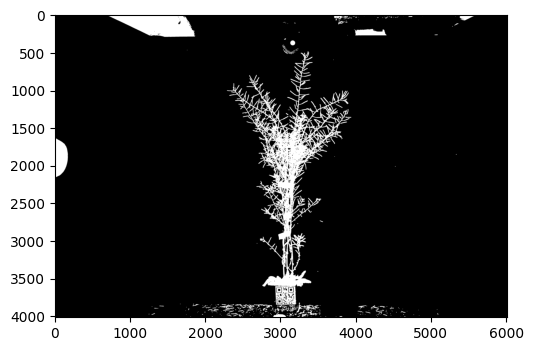

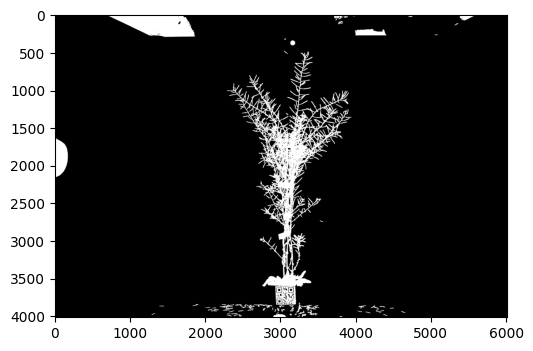

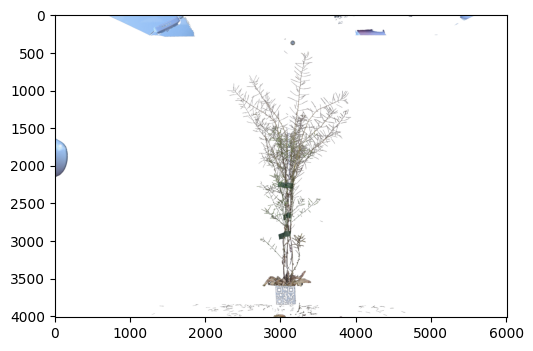

In [12]:
# Fill small objects
hsv_dilated = pcv.dilate(hsv_thresh, 3, 2)
hsv_fill = pcv.fill(hsv_dilated, 250)

# Apply mask (for VIS images, mask_color=white)
masked2 = pcv.apply_mask(masked, hsv_fill, "white")

pcv.print_image(masked2, "hsv_thresh_filled.png")

In [21]:
# Identify objects
id_objects, obj_hierarchy = pcv.find_objects(masked2, hsv_fill)

In [22]:
# Define ROI
roi1, roi_hierarchy= pcv.roi.rectangle(x=2750, y=1000, h=2000, w=500, img=masked2)

<UMat 0x7f4b01d31970>


In [23]:
# Decide which objects to keep
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(masked2, 'partial', roi1, roi_hierarchy, id_objects, obj_hierarchy)

TypeError: Expected Ptr<cv::UMat> for argument 'hierarchy'

In [24]:
# Object combine kept objects
    obj, mask = pcv.object_composition(img, roi_objects, hierarchy3)

NameError: name 'roi_objects' is not defined

In [ ]:
############### Analysis ################

outfile=False
if args.writeimg==True:
    outfile=args.outdir+"/"+filename

    # Find shape properties, output shape image (optional)
    shape_header, shape_data, shape_imgs = pcv.analyze_object(img, obj, mask)
    
    # analysis_images contains two images, the original image with shape data drawn on, and the mask
shape_info_img, shape_mask = shape_imgs
# Plot them out 
pcv.plot_image(shape_info_img)
pcv.plot_image(shape_mask)
pcv.print_image(shape_info_img, "outline_2.png")
pcv.print_image(shape_mask, "mask_2.png")


In [ ]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   bins - Number of color bins (0-256)
#   hist_plot_type - None (default), 'all', 'rgb', 'lab', or 'hsv'
#                    This is the data to be printed to the SVG histogram file  
color_header, color_data, color_histogram = pcv.analyze_color(img, kept_mask, 256, 'all')

# color_histogram is a list containing the histogram image, store it 
color_hist = color_histogram[0]

In [ ]:
# The color_histogram image is a plotnine ggplot; we can plot it to the screen without pcv.plot_image
pcv.plot_image(color_hist)

In [ ]:
# Divide plant object into twenty equidistant bins and assign pseudolandmark points based upon their 
# actual (not scaled) position. Once this data is scaled this approach may provide some information 
# regarding shape independent of size.

top_x, bottom_x, center_v_x = pcv.x_axis_pseudolandmarks(obj, mask, img)

In [ ]:
top_y, bottom_y, center_v_y = pcv.y_axis_pseudolandmarks(obj, mask, img)

In [ ]:
# Write shape and color data to results file
# Result file will go to the notebooks folder! 
result = open(args.result,"a")
result.write('\t'.join(map(str,shape_header)))
result.write("\n")
result.write('\t'.join(map(str,shape_data)))
result.write("\n")
result.write('\t'.join(map(str,color_header)))
result.write("\n")
result.write('\t'.join(map(str,color_data)))
result.write("\n")
result.close()